# Analysis of repeated injections of the same sample using multiple ions

In [1]:
import os
import glycoproteomics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
from pprint import pprint
matplotlib_inline.backend_inline.set_matplotlib_formats("png")
figure_size = (8, 4)
dpi = 100

spectra_directory = "/Users/jonesm5/Dropbox (The Francis Crick)/PlasmaPooled_diann"

Read in all spectra from folder:

In [2]:
spectra = glycoproteomics.io.read_spectra_directory(spectra_directory)
pprint(list(spectra.keys()))

['20210702_Kuebler_56_P2_B1_PlasmaPooled_4.wiff.dia.extracted.txt',
 '20210702_Kuebler_38_P2_B1_PlasmaPooled_3.wiff.dia.extracted.txt',
 '20210702_Kuebler_110_P2_B1_PlasmaPooled_7.wiff.dia.extracted.txt',
 '20210702_Kuebler_20_P2_B1_PlasmaPooled_2.wiff.dia.extracted.txt',
 '20210702_Kuebler_74_P2_B1_PlasmaPooled_5.wiff.dia.extracted.txt',
 '20210702_Kuebler_2_P2_B1_PlasmaPooled_1.wiff.dia.extracted.txt']


Bin the spectra to make them easier to work with and merge

In [3]:
rt_x_bin_size = 0.025
mz_y_bin_size = 2.0

binned_spectra = {
    name: glycoproteomics.spectrum.bin(
        spectrum,
        rt_x_bin_size,
        mz_y_bin_size,
        np.mean)
    for name, spectrum in spectra.items()
}

del(spectra)

Merge the spectra and plot the resulting merged spectrum.

['138.055', '145.05', '163.06', '186.076', '204.087', '274.092', '292.103', '366.14', '512.197', '657.235', '803.293']


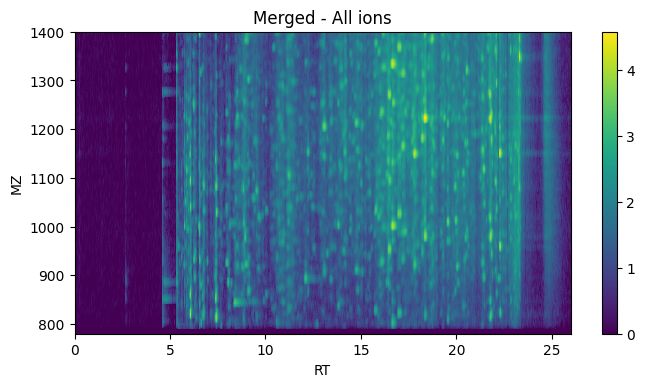

In [4]:
merged_spectrum = glycoproteomics.spectrum.combine(binned_spectra, np.sum)
ions = glycoproteomics.spectrum.list_ions(merged_spectrum)
print(ions)
merged_ion_matrix, x_label, y_label = glycoproteomics.spectrum.to_matrix(merged_spectrum, ions)
glycoproteomics.plotting.plot_ion_matrix(
    merged_ion_matrix,
    x_label,
    y_label,
    "Merged - All ions",
    figure_size,
    dpi
)
plt.show()

Although the merged spectra looks okay, we can do some RT alignment to improve the merging.

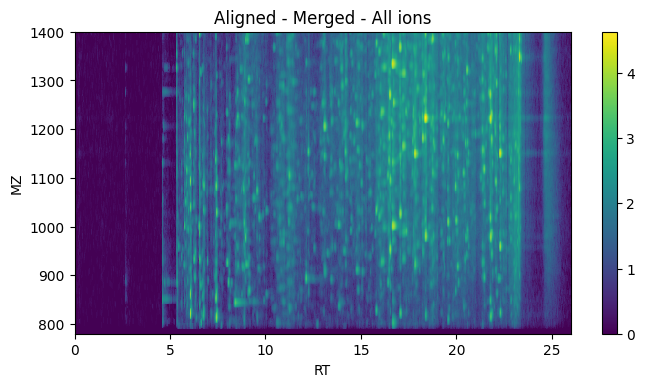

In [5]:
ref_name = list(binned_spectra.keys())[0]

binned_aligned_spectra = {}
rt_alignment_mappings = {}
for name, spectrum in binned_spectra.items():
    aligned_spectrum, rt_alignment = glycoproteomics.spectrum.align_rt(
        spectrum,
        binned_spectra[ref_name],
        1
    )
    binned_aligned_spectra[name] = aligned_spectrum
    rt_alignment_mappings[name] = rt_alignment

merged_spectrum = glycoproteomics.spectrum.combine(binned_aligned_spectra, np.sum)
merged_ion_matrix, x_label, y_label = glycoproteomics.spectrum.to_matrix(merged_spectrum, ions)
glycoproteomics.plotting.plot_ion_matrix(
    merged_ion_matrix,
    x_label,
    y_label,
    "Aligned - Merged - All ions",
    figure_size,
    dpi
)
plt.show()

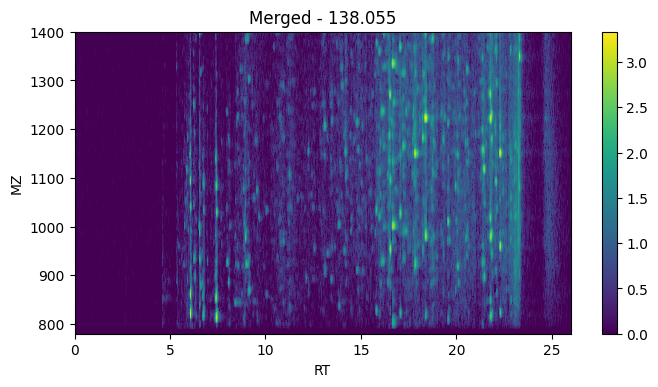

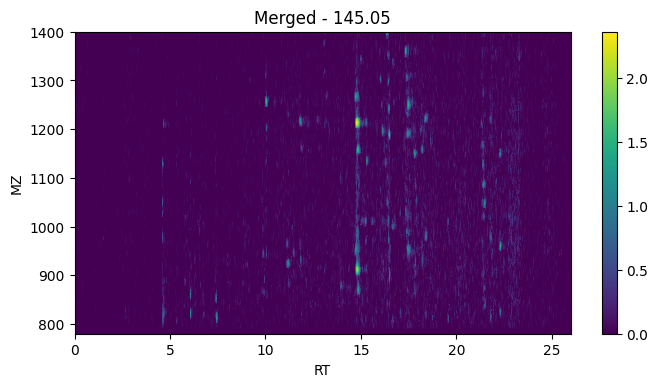

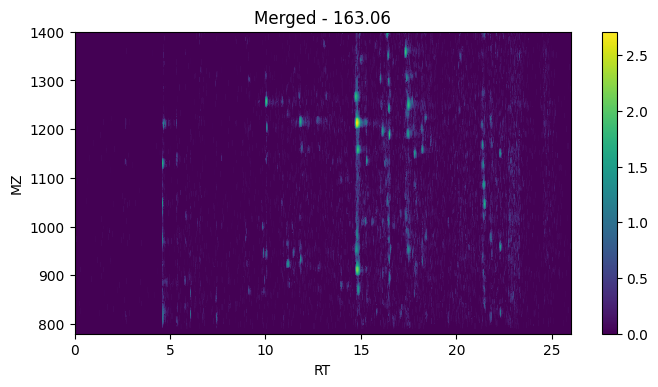

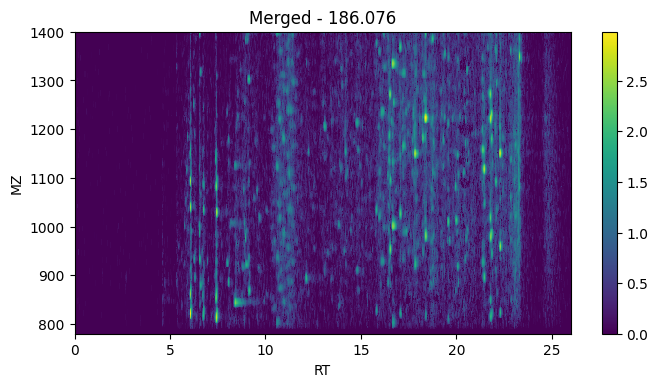

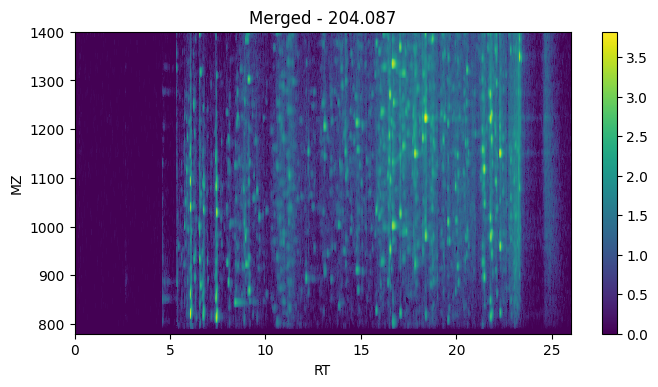

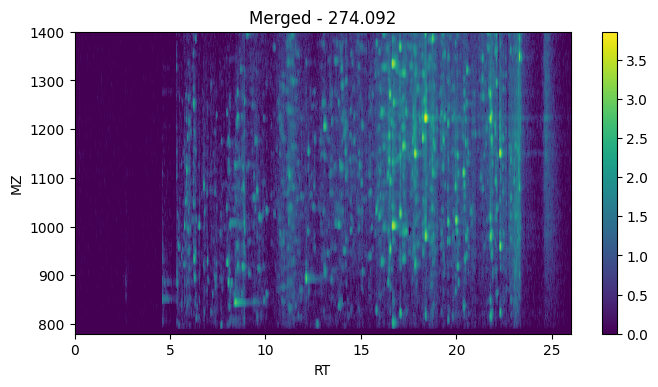

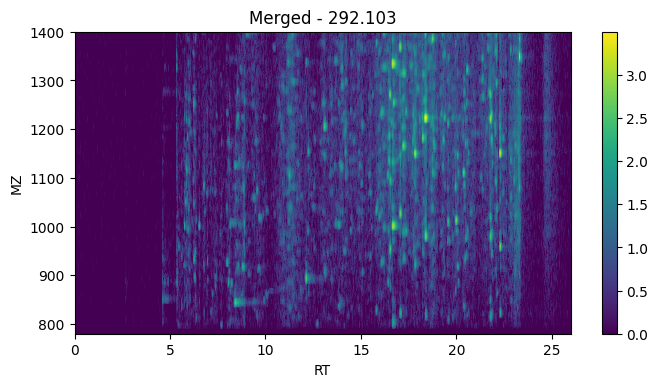

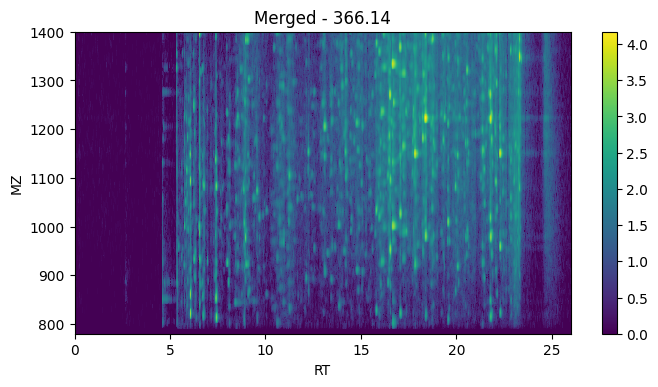

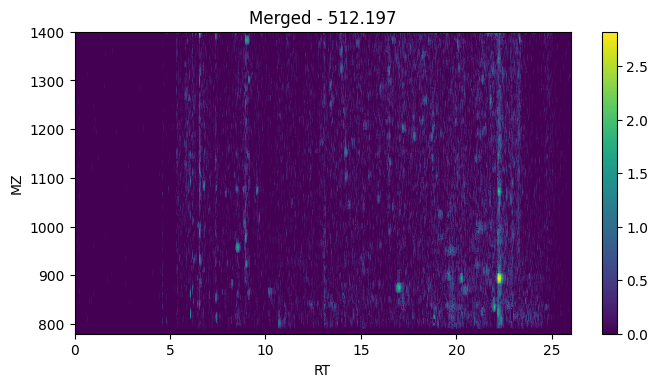

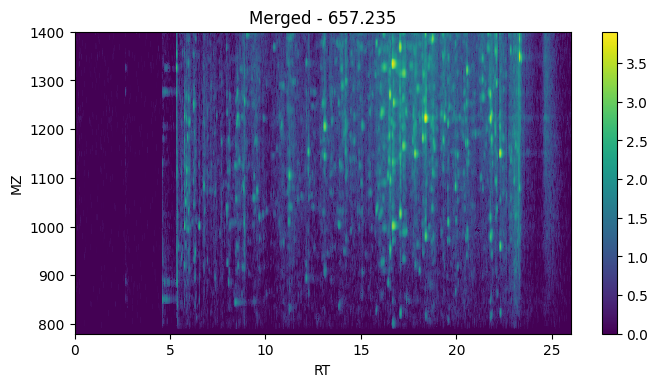

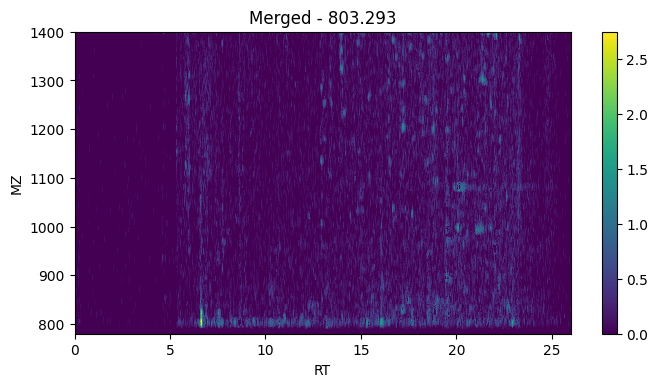

In [6]:
for ion in ions:
    mat, x, y = glycoproteomics.spectrum.to_matrix(merged_spectrum, [ion])
    glycoproteomics.plotting.plot_ion_matrix(
        mat,
        x,
        y,
        "Merged - {}".format(ion),
        figure_size,
        dpi
    )
    plt.show()

Calling the top 100 peaks from the aligned, merged spectrum.

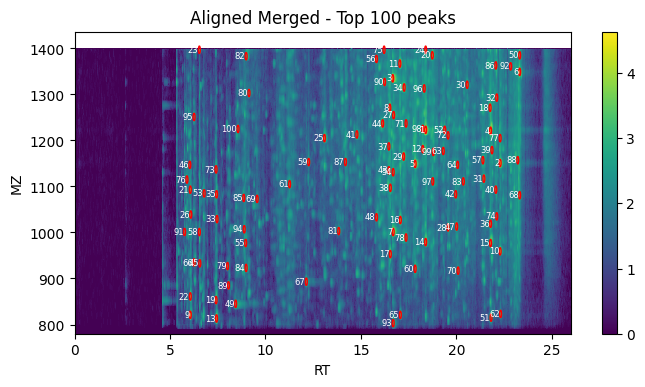

In [7]:
top_N_peaks = 100
x_radius = rt_x_bin_size * 2.0
y_radius = mz_y_bin_size * 4.0

peaks = glycoproteomics.peaks.find(
    merged_ion_matrix,
    x_label,
    y_label,
    top_N_peaks,
    x_radius,
    y_radius
)

glycoproteomics.plotting.plot_ion_matrix_with_peaks(
    merged_ion_matrix,
    x_label,
    y_label,
    peaks,
    x_radius,
    y_radius,
    "Aligned Merged - Top {} peaks".format(top_N_peaks),
    figure_size,
    dpi
)
plt.show()

For each individual spectrum, shift the peak positions (using the RT alignments) and sum all bins within each peak ellipse to generate a value for each peak.

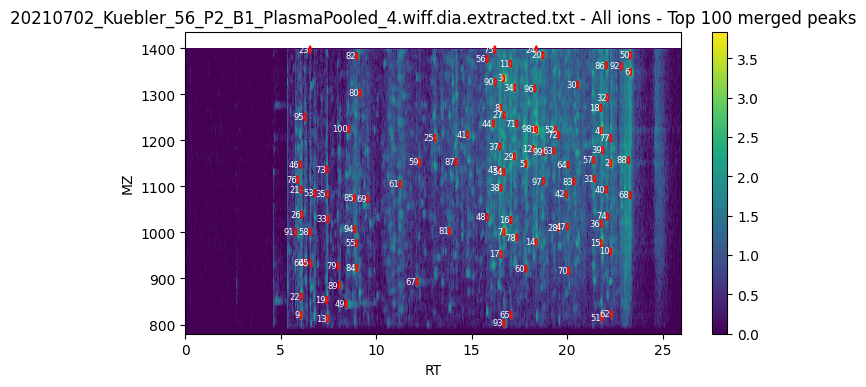

[105878.651038, 50976.570808599994, 48683.014239, 43621.4017436, 38460.922699799994]


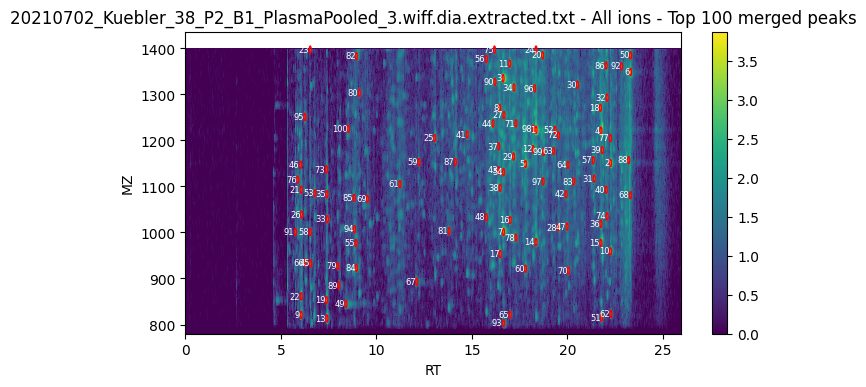

[113264.96293999998, 48567.012549, 55613.173815999995, 43795.920537, 43016.041266199994]


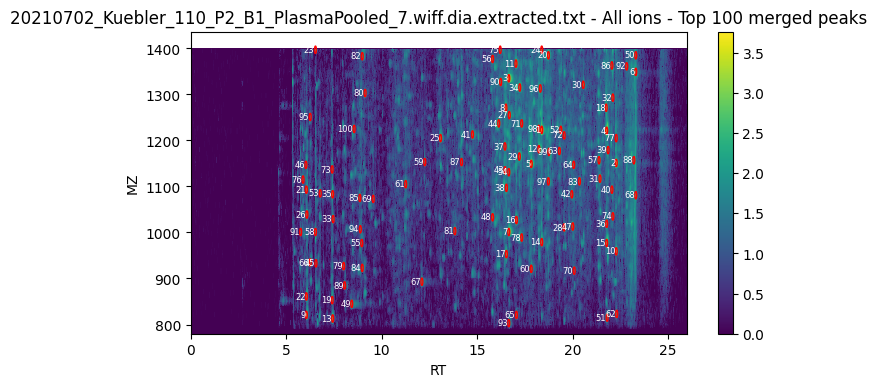

[89874.401117, 43414.072627, 46004.249907000005, 33811.247807199994, 35033.298962999994]


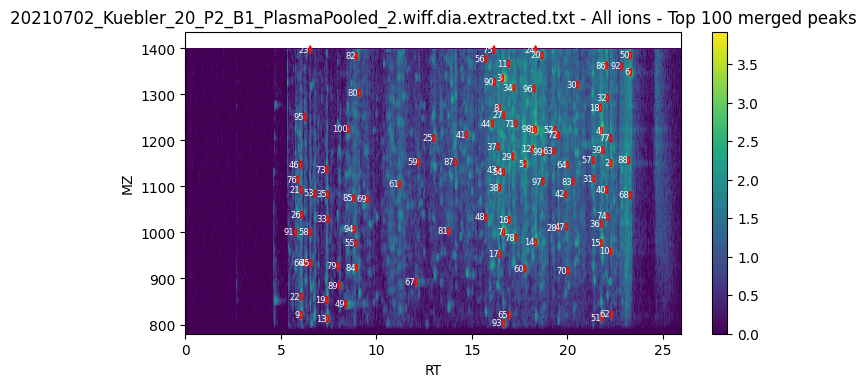

[124699.78740470001, 64485.928636, 52529.941019, 47483.123327999994, 47058.875092999995]


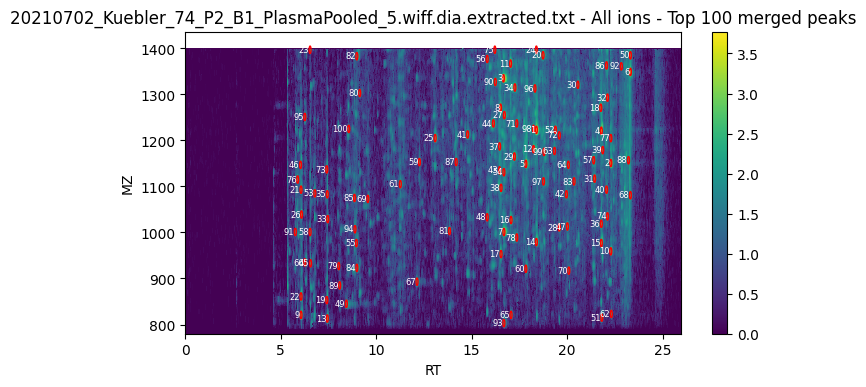

[90099.0760611, 44346.87586, 44986.8854108, 36430.7356446, 31656.1338173]


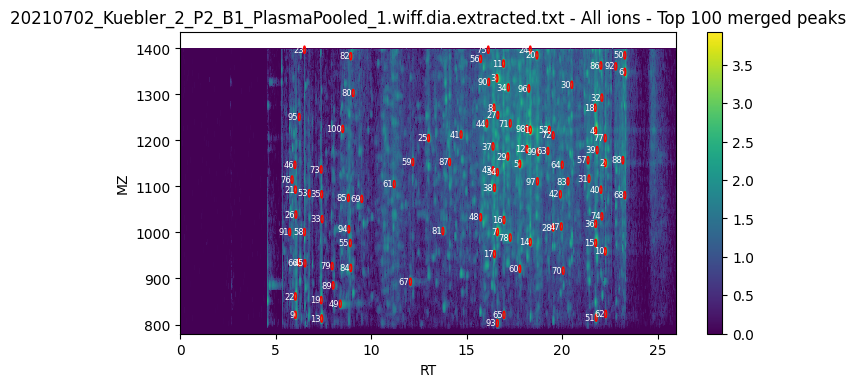

[132829.595178, 55690.298771999995, 53699.1803724, 50820.587938, 49372.305071]


In [8]:
aligned_peak_value_dict = {}
for name, spectrum in binned_spectra.items():
    ion_matrix, x_label, y_label = glycoproteomics.spectrum.to_matrix(spectrum, ions)
    moved_peaks = glycoproteomics.peaks.rt_move(peaks, rt_alignment_mappings[name])
    # Plot the individual spectrum with the merged peaks
    glycoproteomics.plotting.plot_ion_matrix_with_peaks(
        ion_matrix,
        x_label,
        y_label,
        moved_peaks,
        x_radius,
        y_radius,
        "{} - All ions - Top {} merged peaks".format(name, top_N_peaks),
        figure_size,
        dpi
    )
    plt.show()
    # Determine the maximum value within the peak ellipse for each peak
    peak_values = glycoproteomics.peaks.integrate(
        ion_matrix, x_label, y_label, moved_peaks, x_radius, y_radius, np.sum
    )
    aligned_peak_value_dict[name] = peak_values
    # Print the top 5 peaks
    print(peak_values[:5])


Save the peaks to a separate file.

In [9]:
with open("repeat_injection_multiple_ions_aligned_peaks.tsv", "w") as out_f:
    out_f.write("\t".join(["spectrum_name"] +
        ["peak_{}".format(i+1) for i in range(top_N_peaks)]) + "\n")
    for name, peak_values in aligned_peak_value_dict.items():
        out_f.write("\t".join([name] + ["{}".format(i) for i in peak_values]) + "\n")